# Compute Similarity between XAI masks

In [2]:
import os
import cv2
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from tqdm import tqdm
from scipy.stats import wilcoxon
from skimage.transform import AffineTransform, warp
from XAI import attribution_mask_processing


In [ ]:
model_scratch = "VGGNB"
model_pretrained = "NCNN"

path_scratch = f"C:\\Users\\leonardo\\Desktop\\Mestrado\\experiments\\UNIFESP+iCOPE\\{model_scratch}\\xai_masks"
path_pretrained = f"C:\\Users\\leonardo\\Desktop\\Mestrado\\experiments\\UNIFESP+iCOPE\\{model_pretrained}\\xai_masks"



## Load data

In [ ]:
def load_data(path, post_processing=False):

    data = dict()
    path_mesh = 'Datasets\\landmarks'

    for root, _, files in os.walk(path):
        for file in files:
            if file.endswith('.pkl') and file.startswith('ID'):
                image_id = "_".join(file.split("_")[:5])
                xai_path = os.path.join(root, file)

                with open(xai_path, 'rb') as f:
                    mask = pickle.load(f)

                mask = cv2.resize(mask, (512,512), interpolation=cv2.INTER_NEAREST)

                # load face mesh
                i = "_".join(image_id.split("_")[:-1])
                with open(os.path.join(path_mesh,f'{i}.pkl'), 'rb') as f:
                    face_mesh = np.array(pickle.load(f))

                # get class
                label = "nopain" if "nopain" in image_id else "pain"
                xai = "GC" if "GC" in image_id else "IG"

                if post_processing:
                    mask, alpha = attribution_mask_processing(mask)
                    data[image_id] = {'mask': mask, 'alpha': alpha, 'face_mesh': face_mesh, 'label': label, 'xai': xai}
                else:
                    data[image_id] = {'mask': mask, 'alpha': None, 'face_mesh': face_mesh, 'label': label, 'xai': xai}

    return data

In [ ]:
xai_scratch = load_data(path_scratch, post_processing=False)
xai_pretrained = load_data(path_pretrained, post_processing=False)

xai_scratch_post_processed = load_data(path_scratch, post_processing=True)
xai_pretrained_post_processed = load_data(path_pretrained, post_processing=True)

c:\Users\leonardo\Desktop\Mestrado\XAI\attribution_mask_processing.py:62: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  kmeans.fit(flat_mask)
c:\Users\leonardo\Desktop\Mestrado\XAI\attribution_mask_processing.py:62: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  kmeans.fit(flat_mask)
c:\Users\leonardo\Desktop\Mestrado\XAI\attribution_mask_processing.py:62: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  kmeans.fit(flat_mask)
c:\Users\leonardo\Desktop\Mestrado\XAI\attribution_mask_processing.py:62: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  kmeans.fit(flat_mask)
c:\Users\leonardo\Desktop\Mestrado\XAI\attribution_mask_processing.py:62: ConvergenceWarning: Number of 

## Metrics

In [ ]:
# Function to classify pixels by importance
def get_top_k_pixels(xai, k_percent=10):

    # Flatten the map and sort the pixels by importance
    flat_map = xai.flatten()
    threshold_value = np.percentile(flat_map, 100 - k_percent)
    top_k_mask = xai >= threshold_value

    return top_k_mask.astype('int')

In [ ]:
def compare_xais(dict_1, dict_2, metric='iou'):

    metrics = dict()
    
    for image_id in dict_1.keys():
        xai_1 = dict_1[image_id]['mask']
        xai_2 = dict_2[image_id]['mask']

        xai_1 = xai_1.flatten()
        xai_2 = xai_2.flatten()

        if metric == "iou":
            if dict_1[image_id]['alpha'] is None and dict_2[image_id]['alpha'] is None:
                xai_1 = get_top_k_pixels(xai_1, k_percent=10)
                xai_2 = get_top_k_pixels(xai_2, k_percent=10)
            else:
                xai_1 = dict_1[image_id]['alpha']
                xai_2 = dict_2[image_id]['alpha']

            intersection = np.logical_and(xai_1, xai_2)
            union = np.logical_or(xai_1, xai_2)
            iou = np.sum(intersection) / np.sum(union)

            metrics[image_id] = {'IoU': iou, 'XAI': dict_1[image_id]['xai'], 'Label': dict_1[image_id]['label']}

        elif metric == "mse":
            mse = np.mean((xai_1 - xai_2) ** 2)

            metrics[image_id] = {'MSE': mse, 'XAI': dict_1[image_id]['xai'], 'Label': dict_1[image_id]['label']}

        elif metric == "corr":
            corr = np.corrcoef(xai_1, xai_2)[0,1]

            metrics[image_id] = {'Corr': corr, 'XAI': dict_1[image_id]['xai'], 'Label': dict_1[image_id]['label']}

    return metrics

In [ ]:
results_iou = compare_xais(xai_scratch_post_processed, xai_pretrained_post_processed, metric='iou')
results_mse = compare_xais(xai_scratch_post_processed, xai_pretrained_post_processed, metric='mse')
results_corr = compare_xais(xai_scratch_post_processed, xai_pretrained_post_processed, metric='corr')

c:\Users\leonardo\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\leonardo\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


###  IoU

<AxesSubplot:xlabel='XAI', ylabel='IoU'>

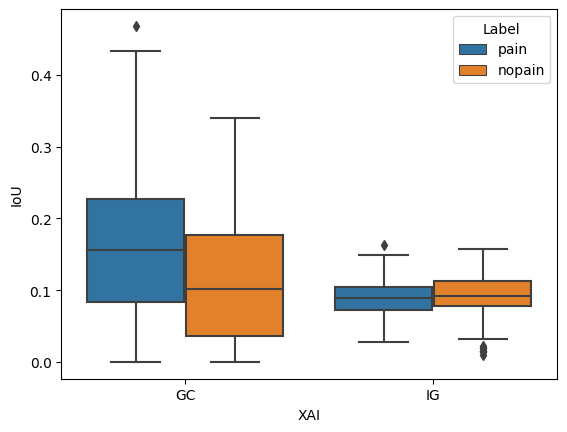

In [ ]:
dataframe_iou = pd.DataFrame.from_dict(results_iou, orient='index')
dataframe_iou.reset_index(inplace=True)
dataframe_iou.rename(columns={'index': 'id'}, inplace=True)

sns.boxplot(x='XAI', y='IoU', hue='Label', data=dataframe_iou)


### MSE

<AxesSubplot:xlabel='XAI', ylabel='MSE'>

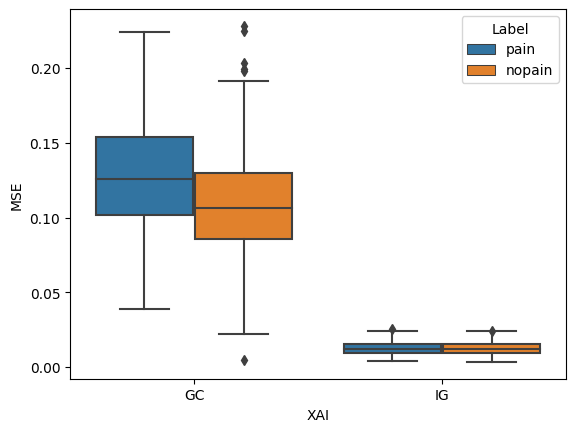

In [ ]:
dataframe_mse = pd.DataFrame.from_dict(results_mse, orient='index')
dataframe_mse.reset_index(inplace=True)
dataframe_mse.rename(columns={'index': 'id'}, inplace=True)

sns.boxplot(x='XAI', y='MSE', hue='Label', data=dataframe_mse)

### Corr

<AxesSubplot:xlabel='XAI', ylabel='Corr'>

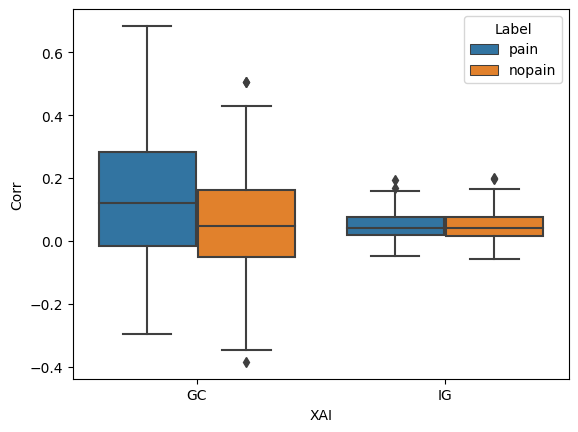

In [ ]:
dataframe_corr = pd.DataFrame.from_dict(results_corr, orient='index')
dataframe_corr.reset_index(inplace=True)
dataframe_corr.rename(columns={'index': 'id'}, inplace=True)

sns.boxplot(x='XAI', y='Corr', hue='Label', data=dataframe_corr)

### Test

In [ ]:
merged_df = dataframe_iou.merge(dataframe_mse[['id','MSE']], on='id').merge(dataframe_corr[['id','Corr']], on='id')
merged_df.to_csv(f'xai_comparison_{model_scratch}_{model_pretrained}.csv', index=False)

In [ ]:
merged_df_VGGNB_NCNN = pd.read_csv('xai_comparison_VGGNB_NCNN.csv')
merged_df_VGGNB_NCNN_PRETRAINED = pd.read_csv('xai_comparison_VGGNB_NCNN_PRETRAINED.csv')
merged_df_NCNN_NCNN_PRETRAINED = pd.read_csv('xai_comparison_NCNN_NCNN_PRETRAINED.csv')

In [ ]:
merged_df_VGGNB_NCNN[merged_df_VGGNB_NCNN['XAI'] == 'GC'].describe()

,IoU,MSE,Corr
count,521.000000,521.000000,504.000000
mean,0.133407,0.117655,0.094004
std,0.095919,0.037216,0.179928
min,0.000000,0.004377,-0.384518
25%,0.053802,0.092345,-0.041890
50%,0.124664,0.113902,0.066222
75%,0.198778,0.143130,0.217486
max,0.468247,0.228167,0.683933


In [ ]:
merged_df_VGGNB_NCNN_PRETRAINED[merged_df_VGGNB_NCNN_PRETRAINED['XAI'] == 'GC'].describe()

,IoU,MSE,Corr
count,521.000000,521.000000,517.000000
mean,0.235548,0.144685,0.250221
std,0.129026,0.043461,0.220323
min,0.000000,0.048198,-0.376898
25%,0.140114,0.113369,0.093543
50%,0.224901,0.141701,0.260652
75%,0.329184,0.173222,0.424128
max,0.587166,0.287899,0.738804


In [ ]:
metric = 'IoU'
XAI = 'GC'

values_scratch = merged_df_VGGNB_NCNN[merged_df_VGGNB_NCNN['XAI'] == XAI][metric].values
values_pretrained = merged_df_VGGNB_NCNN_PRETRAINED[merged_df_VGGNB_NCNN_PRETRAINED['XAI'] == XAI][metric].values

In [ ]:
wilcoxon(values_scratch, values_pretrained)

WilcoxonResult(statistic=11584.0, pvalue=7.444734593431682e-59)

## Vizu

In [ ]:
def visual_compare(dict_1, dict_2, landmarks_mean):
    # Calculate the diff XAI
    metrics = dict()

    transform_rigid = AffineTransform()

    for image_id in tqdm(dict_1.keys()):
        xai_1 = dict_1[image_id]['mask']
        xai_2 = dict_2[image_id]['mask']
        
        face_mesh = dict_1[image_id]['face_mesh']

        landmarks =  np.array([face_mesh[86], 
                                face_mesh[52],
                                face_mesh[61],
                                face_mesh[88],
                                face_mesh[38]])
        
        transform_rigid.estimate(src=landmarks_mean, dst=landmarks)
        xai_1 = warp(xai_1, transform_rigid)
        xai_2 = warp(xai_2, transform_rigid)

        diff = xai_2 - xai_1

        metrics[image_id] = {'diff': diff, 'XAI': dict_1[image_id]['xai'], 'label': dict_1[image_id]['label']}

    return metrics

In [ ]:
faces = []
path_mesh = 'Datasets\\landmarks'
for i in os.listdir(path_mesh):
    with open(os.path.join(path_mesh,f'{i}'), 'rb') as f:
        face_mesh = np.array(pickle.load(f))

    faces.append(face_mesh)

faces_np = np.array(faces)
face_mesh_mean = faces_np.mean(axis=0)

landmarks_mean = np.array([face_mesh_mean[86], 
                        face_mesh_mean[52],
                        face_mesh_mean[61],
                        face_mesh_mean[88],
                        face_mesh_mean[38]])

In [ ]:
results_vizu = visual_compare(xai_scratch_post_processed, xai_pretrained_post_processed, landmarks_mean)

100%|██████████| 1042/1042 [00:10<00:00, 97.49it/s]


In [ ]:
diff_GC_pain = {image_id: data['diff'] for image_id, data in results_vizu.items() if data['label'] == 'pain' and data['XAI'] == 'GC'}
diff_GC_nopain = {image_id: data['diff'] for image_id, data in results_vizu.items() if data['label'] == 'nopain' and data['XAI'] == 'GC'}
diff_GC = {image_id: data['diff'] for image_id, data in results_vizu.items() if data['XAI'] == 'GC'}

diff_IG_pain = {image_id: data['diff'] for image_id, data in results_vizu.items() if data['label'] == 'pain' and data['XAI'] == 'IG'}
diff_IG_nopain = {image_id: data['diff'] for image_id, data in results_vizu.items() if data['label'] == 'nopain' and data['XAI'] == 'IG'}
diff_IG = {image_id: data['diff'] for image_id, data in results_vizu.items() if data['XAI'] == 'IG'}

In [ ]:
from PIL import Image

path_face_images = "Datasets\\DatasetFaces\\Images"
images_list = []

transform_rigid = AffineTransform()

for image_id in diff_GC_pain.keys():
    id = "_".join(image_id.split("_")[:4])
    image_path = os.path.join(path_face_images, id+".jpg")
    image = Image.open(image_path).convert("RGB")
    image = image.resize((512,512))
    image = np.array(image)/255

    with open(os.path.join(path_mesh,f'{id}.pkl'), 'rb') as f:
        face_mesh = np.array(pickle.load(f))

    landmarks =  np.array([face_mesh[86], 
                            face_mesh[52],
                            face_mesh[61],
                            face_mesh[88],
                            face_mesh[38]])

    transform_rigid.estimate(src=landmarks_mean, dst=landmarks)
    image = warp(image, transform_rigid)

    images_list.append(image)

avg_image = np.mean(np.array(images_list), axis=0)

### Average XAI

Text(0.5, 1.0, 'IG')

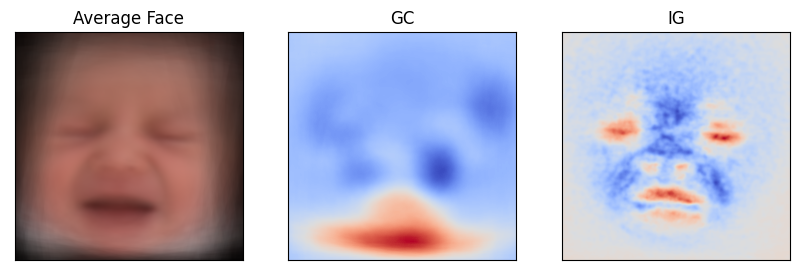

In [ ]:
plt.figure(figsize=(10,5))

plt.subplot(1,3,1)
plt.imshow(avg_image)
plt.xticks([])
plt.yticks([])
plt.title('Average Face')

plt.subplot(1,3,2)
plt.imshow(np.mean(np.array(list(diff_GC.values())), axis=0), cmap='coolwarm')
plt.xticks([])
plt.yticks([])
plt.title('GC')

plt.subplot(1,3,3)
plt.imshow(np.mean(np.array(list(diff_IG.values())), axis=0), cmap='coolwarm')
plt.xticks([])
plt.yticks([])
plt.title('IG')

### Average by class

#### No Pain

Text(0.5, 1.0, 'IG')

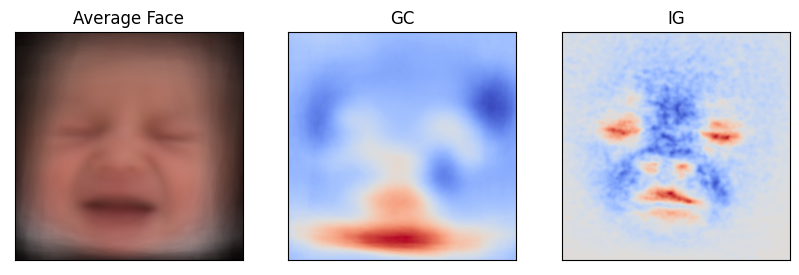

In [ ]:
plt.figure(figsize=(10,5))

plt.subplot(1,3,1)
plt.imshow(avg_image)
plt.xticks([])
plt.yticks([])
plt.title('Average Face')

plt.subplot(1,3,2)
plt.imshow(np.mean(np.array(list(diff_GC_nopain.values())), axis=0), cmap='coolwarm')
plt.xticks([])
plt.yticks([])
plt.title('GC')

plt.subplot(1,3,3)
plt.imshow(np.mean(np.array(list(diff_IG_nopain.values())), axis=0), cmap='coolwarm')
plt.xticks([])
plt.yticks([])
plt.title('IG')

#### Pain

Text(0.5, 1.0, 'IG')

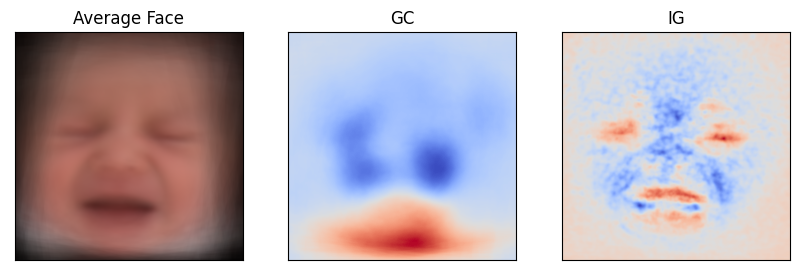

In [ ]:
plt.figure(figsize=(10,5))

plt.subplot(1,3,1)
plt.imshow(avg_image)
plt.xticks([])
plt.yticks([])
plt.title('Average Face')

plt.subplot(1,3,2)
plt.imshow(np.mean(np.array(list(diff_GC_pain.values())), axis=0), cmap='coolwarm')
plt.xticks([])
plt.yticks([])
plt.title('GC')

plt.subplot(1,3,3)
plt.imshow(np.mean(np.array(list(diff_IG_pain.values())), axis=0), cmap='coolwarm')
plt.xticks([])
plt.yticks([])
plt.title('IG')

## Attention Centroid

In [ ]:
import numpy as np
from scipy.ndimage import center_of_mass

def compute_heatmap_centroid(heatmap):
    """
    Computes the weighted centroid of a heatmap.

    The centroid is calculated as the weighted average of the pixel coordinates,
    where the pixel intensities (values between 0 and 1) serve as the weights.

    Parameters
    ----------
    heatmap : numpy.ndarray
        A 2D array representing the heatmap with values in the range [0, 1].

    Returns
    -------
    tuple
        A tuple (y_centroid, x_centroid) representing the centroid coordinates.
    """
    total_weight = np.sum(heatmap)
    if total_weight == 0:
        # If the heatmap is empty or has zero total weight, return the center of the heatmap.
        height, width = heatmap.shape
        return (height / 2, width / 2)

    # Generate index arrays for the y (rows) and x (columns) dimensions.
    y_indices = np.arange(heatmap.shape[0])
    x_indices = np.arange(heatmap.shape[1])
    X, Y = np.meshgrid(x_indices, y_indices)

    # Compute weighted sums of the coordinates.
    x_centroid = np.sum(X * heatmap) / total_weight
    y_centroid = np.sum(Y * heatmap) / total_weight

    return (y_centroid, x_centroid)

# Example usage:
if __name__ == "__main__":
    # Example heatmap: replace with your actual heatmap data
    heatmap = xai_scratch_post_processed['ID1009_UNIFESP_S91_pain_GC']['mask']  # 100x150 heatmap with random values between 0 and 1

    # Compute centroid manually
    centroid_manual = compute_heatmap_centroid(heatmap)
    print("Centroid (manual):", centroid_manual)

    # Alternatively, using SciPy's center_of_mass function:
    centroid_scipy = center_of_mass(heatmap)
    print("Centroid (SciPy):", centroid_scipy)


Centroid (manual): (263.50159096263354, 329.46779133661823)
Centroid (SciPy): (263.50159096263354, 329.46779133661823)


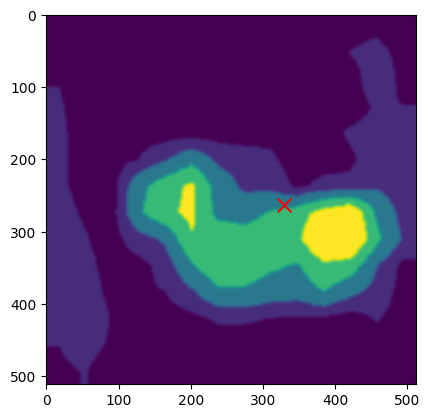

In [ ]:
plt.imshow(xai_scratch_post_processed['ID845_UNIFESP_S76_pain_GC']['mask'])
plt.scatter(centroid_scipy[1], centroid_scipy[0], color='red', marker='x', s=100, label='Centroid')

In [ ]:
xai_scratch_post_processed.keys()

dict_keys(['ID1009_UNIFESP_S91_pain_GC', 'ID1009_UNIFESP_S91_pain_IG', 'ID1010_UNIFESP_S91_pain_GC', 'ID1010_UNIFESP_S91_pain_IG', 'ID1012_UNIFESP_S91_pain_GC', 'ID1012_UNIFESP_S91_pain_IG', 'ID1013_UNIFESP_S91_pain_GC', 'ID1013_UNIFESP_S91_pain_IG', 'ID1024_UNIFESP_S92_pain_GC', 'ID1024_UNIFESP_S92_pain_IG', 'ID1034_UNIFESP_S93_pain_GC', 'ID1034_UNIFESP_S93_pain_IG', 'ID1040_UNIFESP_S94_pain_GC', 'ID1040_UNIFESP_S94_pain_IG', 'ID1048_UNIFESP_S94_pain_GC', 'ID1048_UNIFESP_S94_pain_IG', 'ID1056_UNIFESP_S95_pain_GC', 'ID1056_UNIFESP_S95_pain_IG', 'ID1057_UNIFESP_S95_pain_GC', 'ID1057_UNIFESP_S95_pain_IG', 'ID1083_UNIFESP_S97_pain_GC', 'ID1083_UNIFESP_S97_pain_IG', 'ID1115_UNIFESP_S100_pain_GC', 'ID1115_UNIFESP_S100_pain_IG', 'ID1119_UNIFESP_S100_pain_GC', 'ID1119_UNIFESP_S100_pain_IG', 'ID1128_UNIFESP_S101_pain_GC', 'ID1128_UNIFESP_S101_pain_IG', 'ID1129_UNIFESP_S101_pain_GC', 'ID1129_UNIFESP_S101_pain_IG', 'ID1130_UNIFESP_S101_pain_GC', 'ID1130_UNIFESP_S101_pain_IG', 'ID1132_UNIFESP_S10

# Metrics and XAI during training

In [2]:
# eval_all_checkpoints.py
import csv, json, pathlib, time
from collections import defaultdict

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

from models import NCNN

In [3]:
# ───────────────────────────────────────────────
# 1. CONFIG
# ───────────────────────────────────────────────
ROOT          = pathlib.Path("D:/Doutorado/Cassia Test")
CKPT_DIR      = ROOT / "checkpoints_NCNN_arc_test"

CSV_PATH      = CKPT_DIR / "metrics.csv"
PLOT_PATH     = CKPT_DIR / "metrics_by_epoch.png"



Loss curve saved → D:\Doutorado\Cassia Test\checkpoints_NCNN_arc_test\metrics_loss.png
Accuracy curve saved → D:\Doutorado\Cassia Test\checkpoints_NCNN_arc_test\metrics_accuracy.png


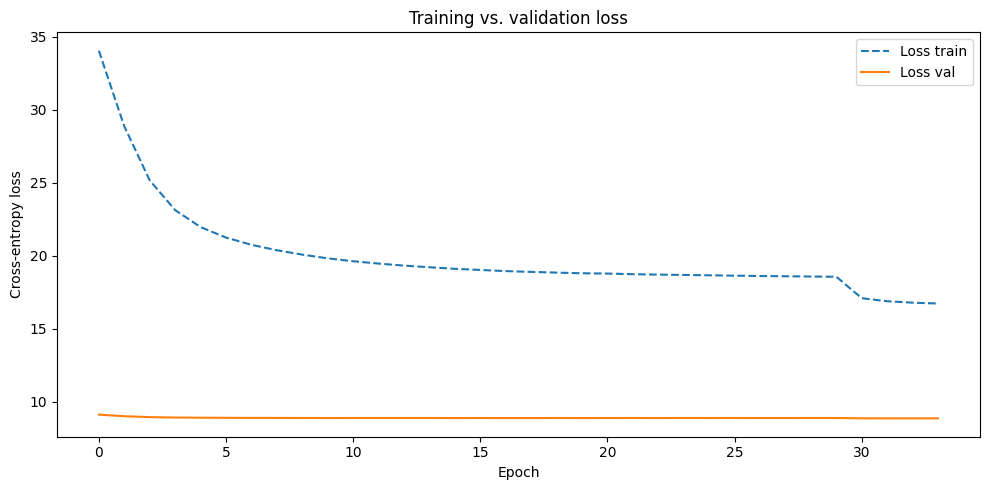

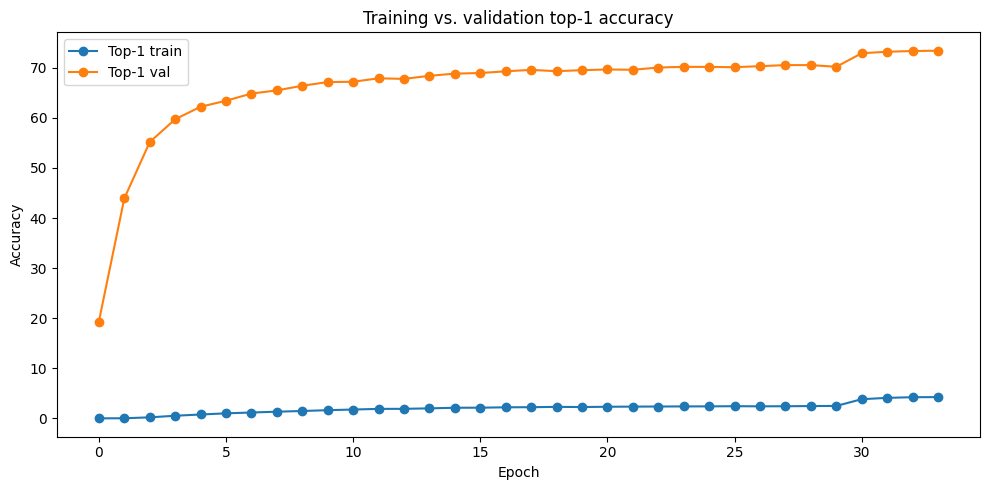

In [4]:
# ─────────── plot after finishing ────────────
df = pd.read_csv(CSV_PATH).sort_values("epoch")

# ------------------------------------------------------------------ #
# 1. LOSS CURVES                                                     #
# ------------------------------------------------------------------ #
fig_loss, ax = plt.subplots(figsize=(10, 5))
ax.plot(df.epoch, df.train_loss, label="Loss train", linestyle="--")
ax.plot(df.epoch, df.val_loss,   label="Loss val")
ax.set_xlabel("Epoch")
ax.set_ylabel("Cross‑entropy loss")
ax.set_title("Training vs. validation loss")
ax.legend()
fig_loss.tight_layout()

loss_path = PLOT_PATH.with_name("metrics_loss.png")
fig_loss.savefig(loss_path, dpi=150)
print(f"Loss curve saved → {loss_path}")

# ------------------------------------------------------------------ #
# 2. ACCURACY CURVES                                                 #
# ------------------------------------------------------------------ #
fig_acc, ax = plt.subplots(figsize=(10, 5))
ax.plot(df.epoch, df.train_acc, label="Top‑1 train", marker="o")
ax.plot(df.epoch, df.test_acc,   label="Top‑1 val",   marker="o")
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
ax.set_title("Training vs. validation top‑1 accuracy")
ax.legend()
fig_acc.tight_layout()

acc_path = PLOT_PATH.with_name("metrics_accuracy.png")
fig_acc.savefig(acc_path, dpi=150)
print(f"Accuracy curve saved → {acc_path}")


In [4]:
df[df['val_loss'] <= df["train_loss"]]

,epoch,train_loss,train_acc,val_loss,test_acc
0,0,34.049657,0.000000,9.114026,19.320603
1,1,28.864202,0.016482,9.002930,43.913570
2,2,25.166701,0.198302,8.942346,55.165843
3,3,23.126577,0.518933,8.914404,59.729687
4,4,21.964716,0.767711,8.901878,62.225632
5,5,21.244884,1.000523,8.893885,63.427672
6,6,20.749047,1.164830,8.889108,64.860348
7,7,20.377332,1.328107,8.886867,65.491664
8,8,20.076325,1.466661,8.883142,66.425933
9,9,19.822553,1.629680,8.879453,67.155953


### XAI

In [1]:
import os
import io
import pathlib
import imageio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
from torchvision import models

from XAI import GradCAM, IntegratedGradients, attribution_mask_processing
from models import *

In [24]:
# ───────────────────────────────────────────────
# CONFIGURATION
# ───────────────────────────────────────────────
# Only change these paths:
ROOT      = pathlib.Path("D:/Doutorado/Cassia Test")
CKPT_DIR  = ROOT / "checkpoints_NCNN_arc_test"
IMG_PATH  = ROOT / "CassiaWebFace/val/000054/00009770.jpg"

DEVICE    = "cuda" if torch.cuda.is_available() else "cpu"

In [25]:
from collections import OrderedDict

Processing Epoch 0
Processing Epoch 1
Processing Epoch 10
Processing Epoch 11
Processing Epoch 12
Processing Epoch 13
Processing Epoch 14
Processing Epoch 15
Processing Epoch 16
Processing Epoch 17
Processing Epoch 18
Processing Epoch 19
Processing Epoch 2
Processing Epoch 20
Processing Epoch 21
Processing Epoch 22
Processing Epoch 23
Processing Epoch 24
Processing Epoch 25
Processing Epoch 26
Processing Epoch 27
Processing Epoch 28
Processing Epoch 29
Processing Epoch 3
Processing Epoch 30
Processing Epoch 31
Processing Epoch 32
Processing Epoch 33
Processing Epoch 4
Processing Epoch 5
Processing Epoch 6
Processing Epoch 7
Processing Epoch 8
Processing Epoch 9


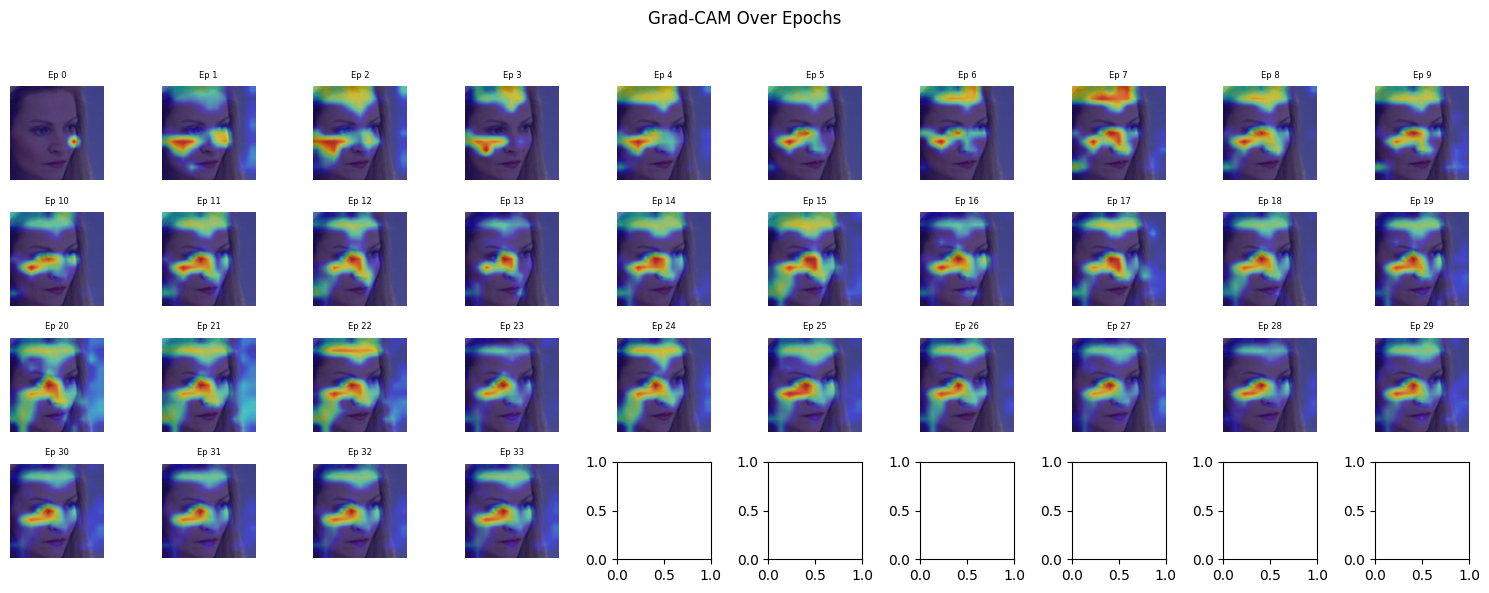

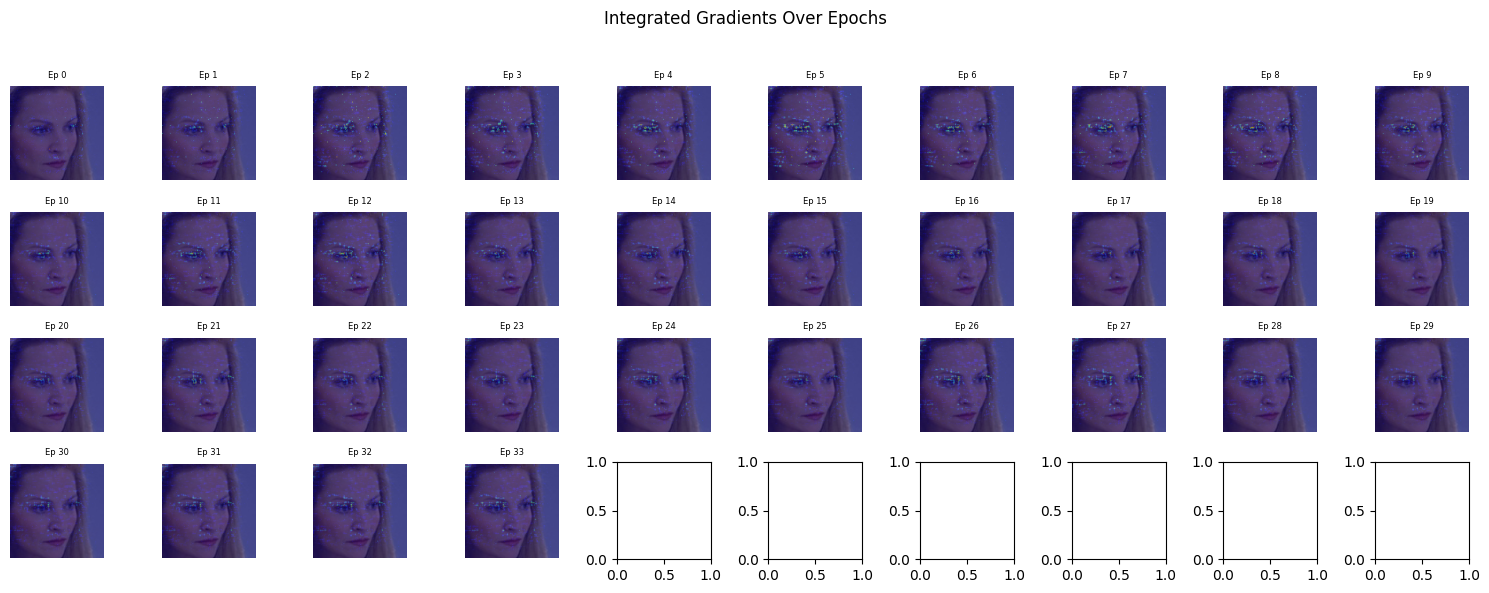

Saved Grad-CAM GIF: gradcam_evolution.gif


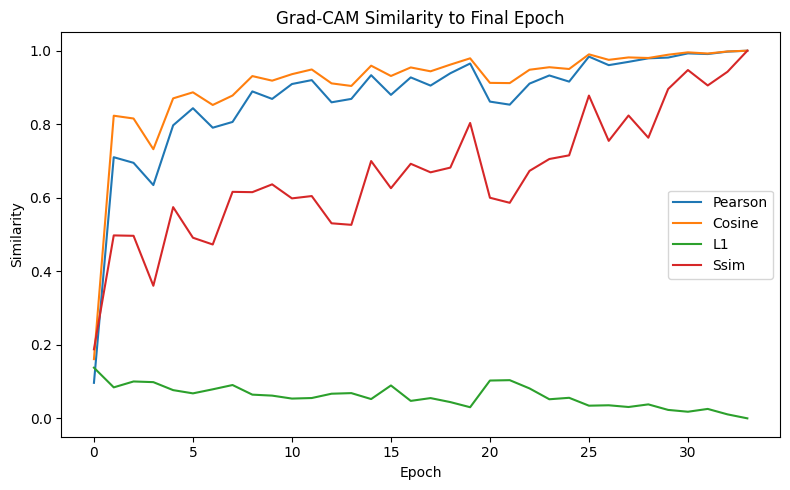

In [26]:


# ───────────────────────────────────────────────
# 1. GENERATE ATTRIBUTION MASKS (GC + IG)
# ───────────────────────────────────────────────
epochs, masks_gc, masks_ig = [], [], []

# Load and preprocess the image once
orig_img = Image.open(IMG_PATH).convert("RGB")


# Build and load your model (edit NCNN class & layer names as needed)
model = NCNN(num_classes=10572)
model.to(DEVICE)
"""


model = models.vgg16(weights=None)
in_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(in_features, 10572)
model.to(DEVICE)
"""


# Image preprocessing: adjust resize_size, img_size, mean, std as needed
resize_size = 152
img_size    = 120
mean, std   = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
tfm = transforms.Compose([
    transforms.Resize(resize_size),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])


for ckpt_path in sorted(CKPT_DIR.glob("checkpoint_*.pth")):
    epoch = int(ckpt_path.stem.split("_")[1])
    print(f"Processing Epoch {epoch}")
    epochs.append(epoch)

    
    ckpt = torch.load(ckpt_path, map_location=DEVICE, weights_only=False)
    ckpt = ckpt.get('model', ckpt)
    ckpt.pop('classifier.weight', None)
    #ckpt.pop('backbone.classifier.bias', None)
    #ckpt.pop('backbone.classifier.weight', None)
    clean_state = OrderedDict(
        (k[9:] if k.startswith("backbone.") else k, v)   # 9 = len("backbone.")
        for k, v in ckpt.items()
    )
    model.load_state_dict(clean_state)

    model.eval()

    # Compute attributions
    ig  = IntegratedGradients(model, device=DEVICE)
    gc  = GradCAM(model, model.merge_branch[0], device=DEVICE)
    #gc  = GradCAM(model, model.features[10], device=DEVICE)

    input_tensor = tfm(orig_img).unsqueeze(0).to(DEVICE)

    mask_ig = ig.attribution_mask(input_tensor)[0]
    mask_gc = gc.attribution_mask(input_tensor)[0]

    masks_ig.append(mask_ig)
    masks_gc.append(mask_gc)

# Build DataFrame
df = pd.DataFrame({
    'epoch': epochs,
    'IG': masks_ig,
    'GC': masks_gc
}).sort_values('epoch').reset_index(drop=True)

# ───────────────────────────────────────────────
# 2. PLOT 10×10 GRID OF OVERLAYS
# ───────────────────────────────────────────────
def plot_grid(masks, title, cols=10, save_path=None):
    rows = int(np.ceil(len(masks) / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(cols*1.5, rows*1.5))
    for i, mask in enumerate(masks):
        r, c = divmod(i, cols)
        ax = axes[r, c]
        if mask.ndim == 2:
            overlay = cm.jet(mask / mask.max())[:, :, :3]
        else:
            overlay = mask
        ax.imshow(orig_img.resize((img_size, img_size)))
        ax.imshow(overlay, alpha=0.5)
        ax.set_title(f"Ep {df.at[i,'epoch']}", fontsize=6)
        ax.axis('off')
    plt.suptitle(title)
    plt.tight_layout(rect=[0,0,1,0.96])
    #if save_path:
        #plt.savefig(save_path, dpi=150)
    plt.show()
    plt.close()

plot_grid(df['GC'].tolist(), title="Grad-CAM Over Epochs", save_path="grid_gc.png")
plot_grid(df['IG'].tolist(), title="Integrated Gradients Over Epochs", save_path="grid_ig.png")

# ───────────────────────────────────────────────
# 3. CREATE EVOLUTION GIF
# ───────────────────────────────────────────────
frames = []
for i, mask in enumerate(df['GC']):
    if mask.ndim == 2:
        overlay = cm.jet(mask / mask.max())[:, :, :3]
    else:
        overlay = mask
    fig, ax = plt.subplots(figsize=(3,3))
    ax.imshow(orig_img.resize((img_size, img_size)))
    ax.imshow(overlay, alpha=0.5)
    ax.set_title(f"Ep {df.at[i,'epoch']}", fontsize=12)
    ax.axis('off')
    buf = io.BytesIO()
    fig.savefig(buf, format='png', dpi=100, bbox_inches='tight', pad_inches=0)
    buf.seek(0)
    frame = imageio.v3.imread(buf)
    frames.append(frame)
    plt.close(fig)

imageio.mimsave("gradcam_evolution.gif", frames, fps=5)
print("Saved Grad-CAM GIF: gradcam_evolution.gif")

# ───────────────────────────────────────────────
# 4. COMPUTE SIMILARITY CURVES
# ───────────────────────────────────────────────
from scipy.stats import pearsonr
from skimage.metrics import structural_similarity as ssim

def flat(x): return x.reshape(-1)

def compute_similarity(masks, ref_mask):
    sims = {'pearson': [], 'cosine': [], 'l1': [], 'ssim': []}
    ref_flat = flat(ref_mask)
    ref_norm = np.linalg.norm(ref_flat) + 1e-12
    for m in masks:
        m_flat = flat(m)
        sims['pearson'].append(pearsonr(m_flat, ref_flat)[0])
        sims['cosine'].append(np.dot(m_flat, ref_flat) / (np.linalg.norm(m_flat)*ref_norm))
        sims['l1'].append(np.mean(np.abs(m_flat - ref_flat)))
        sims['ssim'].append(ssim(m, ref_mask, data_range=ref_mask.max()-ref_mask.min()))
    return sims

ref_gc = df.loc[df['epoch'].idxmax(), 'GC']
sims_gc = compute_similarity(df['GC'].tolist(), ref_gc)
sim_df = pd.DataFrame({'epoch': df['epoch'], **{f'gc_{k}': v for k, v in sims_gc.items()}})

# ───────────────────────────────────────────────
# 5. PLOT SIMILARITY CURVES
# ───────────────────────────────────────────────
plt.figure(figsize=(8,5))
for col in ['gc_pearson', 'gc_cosine', 'gc_l1', 'gc_ssim']:
    plt.plot(sim_df['epoch'], sim_df[col], label=col.replace('gc_', '').title())
plt.xlabel('Epoch')
plt.ylabel('Similarity')
plt.title('Grad-CAM Similarity to Final Epoch')
plt.legend()
plt.tight_layout()
#plt.savefig("gc_similarity.png", dpi=150)
plt.show()
